In [2]:
import numpy as np
from scipy.optimize import linprog
import numpy as np
from collections import defaultdict
import SimpleITK as sitk
import json
import numpy as np

import numpy as np
from collections import defaultdict
import json


import numpy as np


import numpy as np
import SimpleITK as sitk
from collections import defaultdict

# Load the segmentation NIfTI file
file_path = "/Users/seandmello/Downloads/OASIS-TRT-20-10_DKT31_CMA_labels_in_MNI152.nii.gz"
image = sitk.ReadImage(file_path)

# Convert to NumPy array
data = sitk.GetArrayFromImage(image)
print(data)
np.random.seed(100)

# Load the label map of brain
file_path = "/Users/seandmello/Documents/Segmentation_8-BrainLabelMap-label_1.nrrd"
image = sitk.ReadImage(file_path)


# Convert to NumPy array
label_map = sitk.GetArrayFromImage(image)

def add_tumor_to_data(data1, label_map, radius):
    # Find all brain coordinates (label == 1)
    brain_coords = np.argwhere(label_map == 1)  # Assuming 1 represents brain tissue in your segmentation
    
    # Randomly select a point as the tumor center
    tumor_center = brain_coords[np.random.randint(len(brain_coords))]
    
    # Get the shape of the data matrix
    shape = data1.shape
    
    # Add the tumor as a sphere around the tumor center
    for dz in range(-radius, radius + 1):
        for dy in range(-radius, radius + 1):
            for dx in range(-radius, radius + 1):
                if dz**2 + dy**2 + dx**2 <= radius**2:  # Check if within the sphere
                    z, y, x = tumor_center + np.array([dz, dy, dx])
                    if (
                        0 <= z < shape[0] and
                        0 <= y < shape[1] and
                        0 <= x < shape[2] and
                        label_map[z, y, x] == 1  # Ensure the tumor stays within brain tissue
                    ):
                        data1[z, y, x] = 999  # Assign label 999 for the tumor

    return data1, tumor_center


# Parameters for the tumor
tumor_radius = 3  # Radius of the tumor

# Implant the tumor into the data matrix
print("Implanting a random tumor into the data matrix...")
data_with_tumor, tumor_center = add_tumor_to_data(data,label_map, tumor_radius)
unique_labels = np.unique(data_with_tumor)

print(f"Tumor implanted at {tumor_center} with radius {tumor_radius}.")


# Load the segmentation label map
label_map_path = "/Users/seandmello/Downloads/OASIS-TRT-20-10_DKT31_CMA_labels_in_MNI152.nii.gz"
label_map_image = sitk.ReadImage(label_map_path)
label_map = sitk.GetArrayFromImage(label_map_image)

def create_two_sided_beams(tumor_center, num_beams):
    """
    Generate two-sided beams originating from the tumor center.
    Each beam has a direction vector and its opposite.
    """
    beams = []

    # Generate points on a sphere using the Fibonacci sphere method
    phi = (1 + np.sqrt(5)) / 2  # Golden ratio
    for i in range(num_beams):
        z = 1 - (2 * i + 1) / num_beams  # z-coordinates spaced evenly
        radius = np.sqrt(1 - z**2)  # Radius of the circle at height z
        theta = 2 * np.pi * i / phi  # Angle using the golden ratio
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)

        direction = np.array([x, y, z])

        # Each beam has two directions: original and opposite
        beams.append({"start": tumor_center, "direction": direction})
        beams.append({"start": tumor_center, "direction": -direction})  # Opposite direction

    return beams


def calculate_voxels_affected(beams, data_shape, beam_radius):
    """
    Determine which voxels are touched by each beam, given a specific beam radius.
    """
    affected_voxels = defaultdict(list)
    for beam_index, beam in enumerate(beams):
        start = np.array(beam["start"])
        direction = np.array(beam["direction"])
        
        # Move along the beam direction up to the bounds of the 3D space
        for t in range(-beam_radius, beam_radius + 1):
            position = start + t * direction
            voxel = np.round(position).astype(int)  # Convert to voxel indices
            
            # Ensure voxel is within bounds
            if all(0 <= voxel[i] < data_shape[i] for i in range(3)):
                affected_voxels[beam_index].append(tuple(voxel))
    return affected_voxels


def compute_intensity(weights, affected_voxels, data_shape, sigma):
    """
    Compute the intensity experienced by each voxel based on the beam weights.
    """
    intensity_matrix = np.zeros(data_shape)
    for beam_index, weight in enumerate(weights):
        for voxel in affected_voxels[beam_index]:
            z, y, x = voxel

            intensity = weight  
            intensity_matrix[z, y, x] += intensity
    return intensity_matrix


# Generate beams centered at the tumor, with two directions for each beam
num_beams = 10
tumor_center = tumor_center  # From your earlier tumor placement
beams = create_two_sided_beams(tumor_center, num_beams)

# Calculate which voxels are affected by each beam
beam_radius = 100  # Radius of influence for each beam
affected_voxels = calculate_voxels_affected(beams, data_with_tumor.shape, beam_radius)

np.random.seed(1000)
# Define intensity weights for each beam (same weight for both directions)
beam_weights = np.ones(len(beams))# Random integers between 1 and 10 (inclusive)


# Compute the intensity matrix
sigma = 1  # Standard deviation for Gaussian intensity
intensity_matrix = compute_intensity(beam_weights, affected_voxels, data_with_tumor.shape, sigma)
print(np.sum(intensity_matrix))
print("Intensity matrix computed.")

def calculate_total_tumor_intensity(intensity_matrix, data_with_tumor, tumor_label=999):
    """
    Calculate the total intensity delivered to tumor cells.
    
    Args:
        intensity_matrix: 3D array of intensity values.
        data_with_tumor: 3D array with tumor labels (999 for tumor).
        tumor_label: The label value representing tumor cells (default 999).
    
    Returns:
        Total intensity delivered to the tumor cells.
    """
    # Create a mask for tumor voxels
    tumor_mask = (data_with_tumor == tumor_label)
    
    # Sum the intensities in the tumor region
    total_tumor_intensity = np.sum(intensity_matrix[tumor_mask])
    
    return total_tumor_intensity


# Calculate the total intensity going into the tumor cells
total_tumor_intensity = calculate_total_tumor_intensity(intensity_matrix, data_with_tumor)

print(f"Total intensity delivered to tumor cells prior to optimization: {total_tumor_intensity}")

# Step 1: Calculate the dose contributions
def calculate_doses(beams, tumor_mask, normal_mask, intensity_matrix, num_beams, weights, sigma):
    beam_doses_to_tumor = np.zeros(num_beams)
    beam_doses_to_normal = np.zeros(num_beams)
    new_intensity_matrix = np.zeros_like(intensity_matrix)

    for beam_index, beam in enumerate(beams):
        for voxel in affected_voxels[beam_index]:
            z, y, x = voxel

            intensity = intensity_matrix[z,y,x]
            new_intensity_matrix[z, y, x] += intensity

            if tumor_mask[z, y, x]:
                beam_doses_to_tumor[beam_index] += intensity
            elif normal_mask[z, y, x]:
                beam_doses_to_normal[beam_index] += intensity

    return beam_doses_to_tumor, beam_doses_to_normal, new_intensity_matrix

# Step 2: Initialize masks, weights, and parameters
tumor_mask = (data_with_tumor == 999)
normal_mask = (data_with_tumor != 0) & (data_with_tumor != 999)

weights = np.ones(len(beams))  # Initial weights for the beams
beam_doses_to_tumor, beam_doses_to_normal, new_intensity_matrix = calculate_doses(
    beams, tumor_mask, normal_mask, intensity_matrix, len(beams), weights, sigma
)






# Step 3: Set up the linear programming problem

# Objective: Minimize the total dose to normal tissue
c = beam_doses_to_normal  # Coefficients for the objective function

# Constraints: Total tumor dose must equal the prescribed dose
A_eq = [beam_doses_to_tumor]
b_eq = [10000]  # Prescribed tumor dose

# Bounds for beam weights (e.g., between 0 and upper_bound)
upper_bound = 50 
bounds = [(0, upper_bound) for _ in range(len(beams))]

# Step 4: Solve the linear programming problem
result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")

# Step 5: Check results
if result.success:
    optimal_beam_weights = result.x
    print("Optimal beam weights:", optimal_beam_weights)
    print("Minimum normal tissue dose:", result.fun)

    calculated_tumor_dose = np.dot(beam_doses_to_tumor, optimal_beam_weights)
    print("Total tumor dose (verification):", calculated_tumor_dose)
else:
    print("Optimization failed:", result.message)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
Implanting

In [10]:
from scipy.optimize import differential_evolution

# Define objective function
def objective_function(w):
    beam_doses_to_tumor_total = np.dot(beam_doses_to_tumor, w)
    normal_tissue_dose = np.dot(beam_doses_to_normal, w)
    if beam_doses_to_tumor_total < 10000:  # Penalize underdosing
        return normal_tissue_dose + 1000 * (10000 - beam_doses_to_tumor_total)
    return normal_tissue_dose

# Bounds for weights
bounds = [(0, 50) for _ in range(len(beams))]

# Solve with differential evolution
result = differential_evolution(objective_function, bounds)

if result.success:
    print("Optimal weights:", result.x)
    print("Minimum normal tissue dose:", result.fun)
    print("Tumor Tissue Dose:", np.dot(beam_doses_to_tumor, result.x))

else:
    print("Optimization failed:", result.message)


Optimal weights: [32.1310998  31.8801453   0.17328381  0.11800926 44.19351299 25.31827546
  0.29276656  0.12840786  0.80168032  0.08123926  0.63605846  0.08127255
  0.23844512  0.34060018  0.2698151   1.08303931 48.66111242 49.81205687
  0.1759805   1.08852581]
Minimum normal tissue dose: 15281.184793112347
Tumor Tissue Dose: 10001.617315272531


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      1 |             - |             -
     2 |      200 |      1 |  4.414869E+15 |         ideal
     3 |      300 |      1 |  9.071419E+15 |         ideal
     4 |      400 |      1 |  0.000000E+00 |             f
     5 |      500 |      2 |  3.5851496113 |         ideal
     6 |      600 |      1 |  2.164460E+15 |         ideal
     7 |      700 |      1 |  1.084291E+15 |         ideal
     8 |      800 |      2 |  2.3084657669 |         ideal
     9 |      900 |      1 |  2.162207E+14 |         ideal
    10 |     1000 |      3 |  1.7672631881 |         ideal
    11 |     1100 |      2 |  1.0323170044 |         ideal
    12 |     1200 |      1 |  9.389192E+13 |         ideal
    13 |     1300 |      2 |  1.793790E+01 |         ideal
    14 |     1400 |      2 |  1.482254E+01 |         ideal
    15 |     1500 |      1 |  2.584237E+13 |         ideal
    16 |     1600 |      1 |  3.258536E+12 |         ide

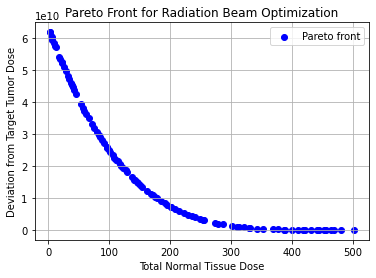

In [46]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
import numpy as np

# Define the multi-objective optimization problem
class RadiationOptimization(Problem):
    def __init__(self, beam_doses_to_normal, beam_doses_to_tumor, prescribed_tumor_dose, upper_bound=50):
        super().__init__(n_var=len(beam_doses_to_normal),
                         n_obj=2,
                         n_constr=0,
                         xl=0,  # Lower bounds for beam weights
                         xu=upper_bound)  # Upper bounds for beam weights
        self.beam_doses_to_normal = beam_doses_to_normal
        self.beam_doses_to_tumor = beam_doses_to_tumor
        self.prescribed_tumor_dose = prescribed_tumor_dose

    def _evaluate(self, x, out, *args, **kwargs):
        # Calculate total dose to normal tissue (Objective 1)
        normal_tissue_dose = np.dot(self.beam_doses_to_normal, x.T)

        # Calculate deviation from prescribed tumor dose (Objective 2)
        tumor_dose = np.dot(self.beam_doses_to_tumor, x.T)
       
        tumor_dose_deviation = (tumor_dose - self.prescribed_tumor_dose)**4

        out["F"] = np.column_stack([normal_tissue_dose, tumor_dose_deviation])
        #out["F"] = np.column_stack([normal_tissue_dose, tumor_dose])

# Problem parameters
prescribed_tumor_dose = 500
upper_bound = 50

# Create the optimization problem
problem = RadiationOptimization(beam_doses_to_normal, beam_doses_to_tumor, prescribed_tumor_dose, upper_bound)

# Use NSGA-II for multi-objective optimization
algorithm = NSGA2(pop_size=100)

# Perform the optimization
result = minimize(problem, algorithm, termination=('n_gen', 200), seed=1, verbose=True)

# Extract Pareto-optimal solutions
pareto_weights = result.X  # Beam weights
pareto_objectives = result.F  # Corresponding objective values

# Display the Pareto front
print("Pareto-optimal solutions (weights):")
print(pareto_weights)
print("Pareto front (objective values):")
print(pareto_objectives)

# Plot Pareto front
import matplotlib.pyplot as plt
plt.scatter(pareto_objectives[:, 0], pareto_objectives[:, 1], c="blue", label="Pareto front")
plt.xlabel("Total Normal Tissue Dose")
plt.ylabel("Deviation from Target Tumor Dose")
plt.title("Pareto Front for Radiation Beam Optimization")
plt.legend()
plt.grid(True)
plt.show()
